## TROPOMI-AERONET Collocation Analysis Tool ##

- This script performs collocation analysis between Level 2 (L2) TROPOMI satellite aerosol optical depth (AOD) measurements and ground-based AERONET observations for validation and comparison purposes. 

- The tool matches satellite pixels within 25 km of each AERONET site with AERONET observations averaged within ±0.5 hours of the satellite overpass time (these matching criteria are adjustable.) 

- Users can add additional satellite datasets as needed by following the TROPOMI implementation example. 

### Author: Xiaohua Pan
- Email: xiaohua.pan@nasa.gov
- Organization: NASA Goddard Space Flight Center
- Date Created: 09/02/2025
- Last Modified: 11/17/2025

### Features:
- Downloads TROPOMI data from NASA Earthdata
- Retrieves AERONET data from web services
- Performs spatial and temporal matching with user-defined criteria
- Generates visualization and statistical analysis outputs

### Data Collocation Process 
#### Step 1: Establish Collocation Criteria (User-Adjustable) 
- Default Spatial Criteria: Satellite pixels within a 25 km radius of each AERONET site
- Default Temporal Criteria: AERONET observations averaged within ±0.5 hours of satellite overpass time
- Sample Use Case: AOD analysis during Los Angeles wildfire events (January 8-12, 2025)

  #### Implementation Note:
- Initial analyses should utilize small spatial domains (approximately 2° × 2°) to minimize processing time
- Short temporal periods (5 days or less) are recommended for initial testing

#### Step 2: Data Acquisition
- AERONET Data: Retrieve AOD observations from sites within the defined spatial domain and temporal range
- TROPOMI Data: Access L2 AOD swath data covering the corresponding spatial and temporal parameters

#### Step 3: Spatial Collocation
- Identify TROPOMI L2 AOD pixels falling within 25 km of each AERONET site
- Calculate statistical metrics (mean, standard deviation) of AOD values from collocated pixels
- Define satellite overpass time as the mean acquisition time of collocated pixels within 25 km of each AERONET site

#### Step 4: Temporal Collocation
- Match satellite observations with AERONET data averaged within ±0.5 hours of satellite overpass time
- Create paired satellite-ground observation datasets using datetime as satellite passing time

#### Step 5: Visualization and Analysis
- Collocation Map: Generate spatial representation of successfully collocated AERONET sites
- Time Series Analysis: Produce temporal plots of collocated AERONET and TROPOMI L2 AOD measurements at each site
- Correlation Analysis: Create scatter plots comparing collocated measurements for individual sites and aggregate data across all locationsStep 

### Input data:
- AERONET: version 3, level 1.5 or level 2 (https://aeronet.gsfc.nasa.gov/print_web_data_help_v3_new.html)
     - Temporal coverage: vary from site to site
     - Temporal resolution: every 3-15 minutes
     - Spatial coverage: global

- TROPOMAER: version 1, level 2 (https://doi.org/10.5067/MEASURES/AER/DATA204)
     - Temporal coverage: 2018-04-30 to present
     - Temporal resolution: once per day
     - Spatial coverage: global
     - Spatial resolution: 7.5km x 3km 

### Output:
All outputs are saved in the output_dir
- /plots: Map of AERONET sites with valid data; scatter plots (aggregate and per-site) and time series (per-site)
- /data: Collocation results exported in CSV format
- /logs: initialization.log 

### Requirements:
- Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login) 
- Earthdata prerequisite Files (https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Python packages: earthaccess, pandas, numpy, matplotlib, requests, BeautifulSoup4, netCDF4

### Tested Configurations:
This notebook was tested succussfully in the configurations below
- Mac OS, Python 3.11.0, NetCDF4 1.6.2 
- Red Hat Enterprise Linux 8.10, Python 3.12.2, NetCDF4 1.6.2
- Google colab 
### Caveats:
- It is possible that no AERONET sites or TROPOMI swaths fall within the specified search domain.
- Collocated observations may not be found for the selected criteria.
- AERONET data downloads may fail due to server limitations (timeout errors—retry later)
- Downloaded TROPOMI files may be corrupted; verify before processing
- Use a text viewer (e.g., vim, not Microsoft Excel) to view downloaded CSV AERONET data in ./data to ensure dates are in DD:MM:YYYY format

### Version History:
- v1  - [09/12/2025] - [Xiaohua Pan]
    - Initial stakeholder demonstration
    
- v2  - [09/25/2025] - [Xiaohua Pan]
    - Match the satellite with the nearest AERONET observation within ±0.5 hours of satellite passing time.
    
- v3 - [10/03/2025] - [Xiaohua Pan]
    - Bin AERONET measurements into 1-hour intervals and collocates the satellite with the closest bin  
    
- v4 - [10/30/2025] - [Xiaohua Pan]
    - Match the satellite with the AERONET observation averaged within ±0.5 hours of satellite overpass time
    
- v5 - [11/17/2025] - [Xiaohua Pan]
    - Match the satellite with the AERONET observation averaged within ±0.5 hours of satellite overpass time
    - Fixed some collocation issues found in v4. 
    
### Acknowledgments:
- ChatGSFC AI assistant used for code improvement and debugging
- NASA GES DISC colleagues, especially Thomos Hearty for validating and Christopher Battisto for publishing this notebook. 
- TROPOMI aerosol data provided by ESA/NASA MEaSUREs program
- AERONET data courtesy of NASA/GSFC AERONET team
    
### Disclaimer:
This software is provided "as is" without any warranty of any kind, either 
expressed, implied, or statutory, including, but not limited to, any warranty 
that the software will conform to specifications, any implied warranties of 
merchantability, fitness for a particular purpose, and freedom from infringement.

---

### 1. Initial Setup

Every time we run this Colab notebook from scratch, we must install missing Python libraries and `curl` the `AOD_Collocation.py` script, hosted in the `utils` folder of the gesdisc-tutorials Github repository (https://github.com/nasa/gesdisc-tutorials/tree/main/utils/AOD_collocation_v5.py)

In [ ]:
! pip install earthaccess
! pip install cartopy
! pip install netCDF4
! curl -L -O https://raw.githubusercontent.com/nasa/gesdisc-tutorials/refs/heads/main/utils/AOD_collocation_v5.py

### 2. Import Libraries

In [1]:
# Import modules
from AOD_collocation_v5 import *

### 3. Initialization Parameters

In [2]:
# Main Collocation program 
print("TROPOMI-AERONET Aerosol Data Collocation Script")
print(" " * 70)

print("Note: User can redefine the initialized parameters below:")
# Define collocation criteria
spatial_radius_km = 25.0       # Spatial matching radius in km
temporal_window_hours = 0.5    # Temporal matching window in hours 

# Define target wavelength for AERONET comparison
target_wavelength = 380  # Common AERONET wavelengths: 340, 380, 440, 500, 675, etc.

print(f"\nCollocation Parameters:")
print(f"  - Spatial radius of an AERONET site: {spatial_radius_km} km")
print(f"  - Temporal window: ±{temporal_window_hours} hours")
print(f"  - Target AERONET wavelength: {target_wavelength} nm")
            
# Define AERONET data format 
aeronet_data_type = 'AOD15'  # e.g., AOD20 = Level 2.0; AOD15 = Level 1.5 
aeronet_data_format = 10     # e.g., 0 = all points; 20 = Daily Average

print(f"\nAERONET Configuration:")
print(f"  - Data type: {aeronet_data_type}")
print(f"  - Data format: {aeronet_data_format}")  

# Define TROPOMI AOD data 
tropomi_data_shortname = "TROPOMAER"
tropomi_data_version = '1' 

print(f"\nTROPOMI Configuration:")
print(f"  - Data shortname: {tropomi_data_shortname}")
print(f"  - Data version: {tropomi_data_version}")

TROPOMI-AERONET Aerosol Data Collocation Script
                                                                      
Note: User can redefine the initialized parameters below:

Collocation Parameters:
  - Spatial radius of an AERONET site: 25.0 km
  - Temporal window: ±0.5 hours
  - Target AERONET wavelength: 380 nm

AERONET Configuration:
  - Data type: AOD15
  - Data format: 10

TROPOMI Configuration:
  - Data shortname: TROPOMAER
  - Data version: 1


### 4. Define Use Case

In [3]:
# Case study 1: LA wildfires
print("Define your use case: \n")

# Define output directory, changing it with use case
output_dir = "./Results_AOD_collocation_LA_v5"
print(f" Output directory: {output_dir}")

# Define analysis period 
print(" Note: Initial analyses should utilize shorter time period (e.g., 5 days) and small spatial domains (approximately 4° × 4°) to minimize processing time")
start_date = datetime(2025, 1, 5)
end_date = datetime(2025, 1, 12)

# Define region of interest (a bounding box) with the longitude range: -180 to 180
# print(f" Region of interest: ")  
# Southern California surrounding Los Angeles 
selected_bbox = {
    'min_lon': -119.5,  # Western boundary
    'max_lon': -115.5,  # Eastern boundary
    'min_lat': 34.0,    # Southern boundary
    'max_lat': 36.0     # Northern boundary
}


# Case study 2: Canadian wildfire 
#  # Define output directory, changing it with use case
#  output_dir = "./Results_AOD_collocation_MD"

# # Define analysis period    
#  start_date = datetime(2023, 6, 3)
#  end_date = datetime(2023, 6, 13)

#  # Define region of interest (a bounding box) with the longitude range: -180 to 180
#  # Maryland
#  selected_bbox = {
#        'min_lon': -78.,  # Western boundary
#        'max_lon': -76.,  # Eastern boundary
#        'min_lat': 38.,    # Southern boundary
#        'max_lat': 40.     # Northern boundary
#    }

print(f" \n Analysis period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")                
print(f" \n Region of interest:")
print(f" - Longitude: {selected_bbox['min_lon']} to {selected_bbox['max_lon']}")
print(f" - Latitude: {selected_bbox['min_lat']} to {selected_bbox['max_lat']}")

Define your use case: 

 Output directory: ./Results_AOD_collocation_LA_v5
 Note: Initial analyses should utilize shorter time period (e.g., 5 days) and small spatial domains (approximately 4° × 4°) to minimize processing time
 
 Analysis period: 2025-01-05 to 2025-01-12
 
 Region of interest:
 - Longitude: -119.5 to -115.5
 - Latitude: 34.0 to 36.0


### 5. Begin Analysis

TROPOMI-AERONET Collocation Analysis Initialized
  Spatial radius: 25.0 km
  Temporal window: ±0.5 hours
  Target wavelength: 380 nm
  Output directory: ./Results_AOD_collocation_LA_v5
  Analysis period: 2025-01-05 to 2025-01-12
  Region of interest:
    Longitude: -119.5 to -115.5
    Latitude: 34.0 to 36.0
  AERONET data type: AOD15
  AERONET data format: 10
  TROPOMI product's shortname': TROPOMAER
  TROPOMI product's version': 1

Successfully initialized TROPOMI-AERONET collocation system
  Found 5 AERONET sites in region
  Spatial radius: 25.0 km
  Temporal window: ±0.5 hours
  Output directory: ./Results_AOD_collocation_LA_v5

AERONET sites in selected region:
  - MISR-JPL: lat=34.1990°, lon=-118.1744°, elev=367.0 m
  - TABLE_MOUNTAIN_CA: lat=34.3800°, lon=-117.6800°, elev=2200.0 m
  - Goldstone: lat=35.2333°, lon=-116.7917°, elev=1100.0 m
  - CalTech: lat=34.1367°, lon=-118.1262°, elev=260.0 m
  - Bakersfield: lat=35.3315°, lon=-119.0000°, elev=108.0 m
Searching and downloading 

QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]


Found 11 TROPOMI files in ./Results_AOD_collocation_LA_v5/data/TROPOMAER.1
Initialization details logged to: ./Results_AOD_collocation_LA_v5/logs/initialization.log

Starting collocation process...
     
Searching AERONET data for MISR-JPL...
 Loop through--> https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=MISR-JPL&year=2025&month=1&day=5&year2=2025&month2=1&day2=12&AOD15=1&AVG=10
os.path.getsize(tmp_csv_file) 12152
Downloaded AERONET data for MISR-JPL
0     2025-01-05 16:03:40
1     2025-01-05 16:13:40
2     2025-01-05 16:28:40
3     2025-01-05 16:32:21
4     2025-01-05 16:41:28
              ...        
300   2025-01-12 22:19:48
301   2025-01-12 22:35:38
302   2025-01-12 22:37:39
303   2025-01-12 22:41:35
304                   NaT
Name: datetime, Length: 305, dtype: datetime64[ns]
Selected AOD column: AOD_380nm (wavelength: 380nm)
Loaded 281 AERONET measurements using AOD_380nm
Using AERONET AOD at 380nm for MISR-JPL
     
Searching AERONET data for TABLE_MOUNTAIN_CA...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


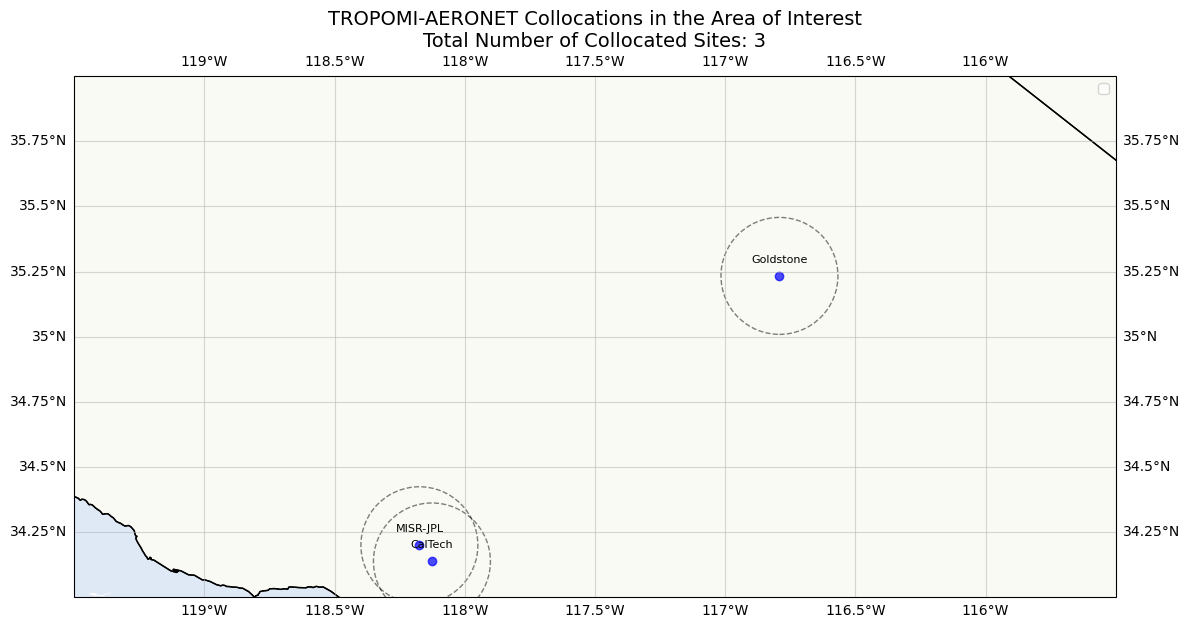


Generating validation scatter plot for all 3 sites...
  - Saved validation scatter plot: ./Results_AOD_collocation_LA_v5/plots/validation_scatter_all_sites_380nm.png


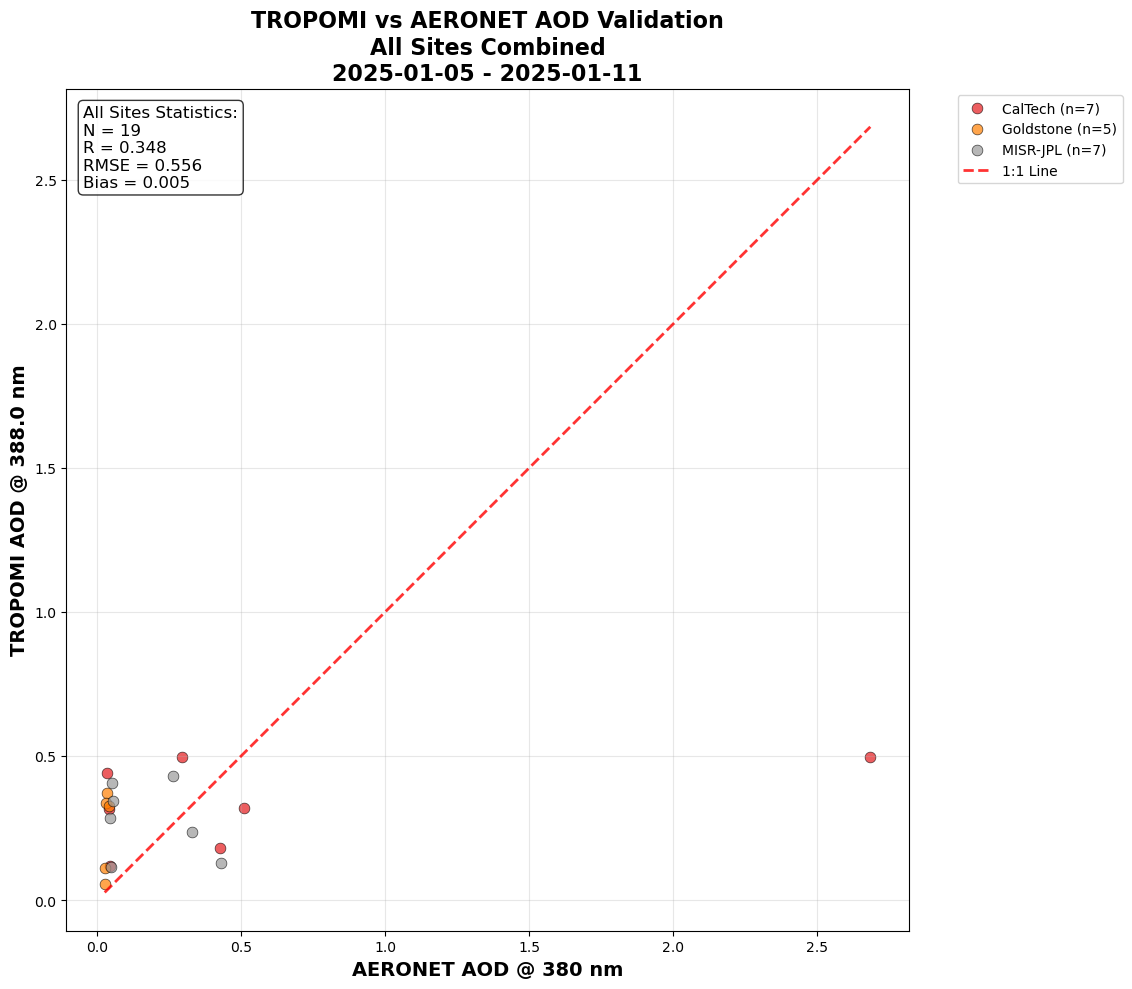


Generating time series and scatter plots for each site...
  - Created plots for CalTech
     Time series plot saved for CalTech: ./Results_AOD_collocation_LA_v5/plots/time_series_CalTech.png


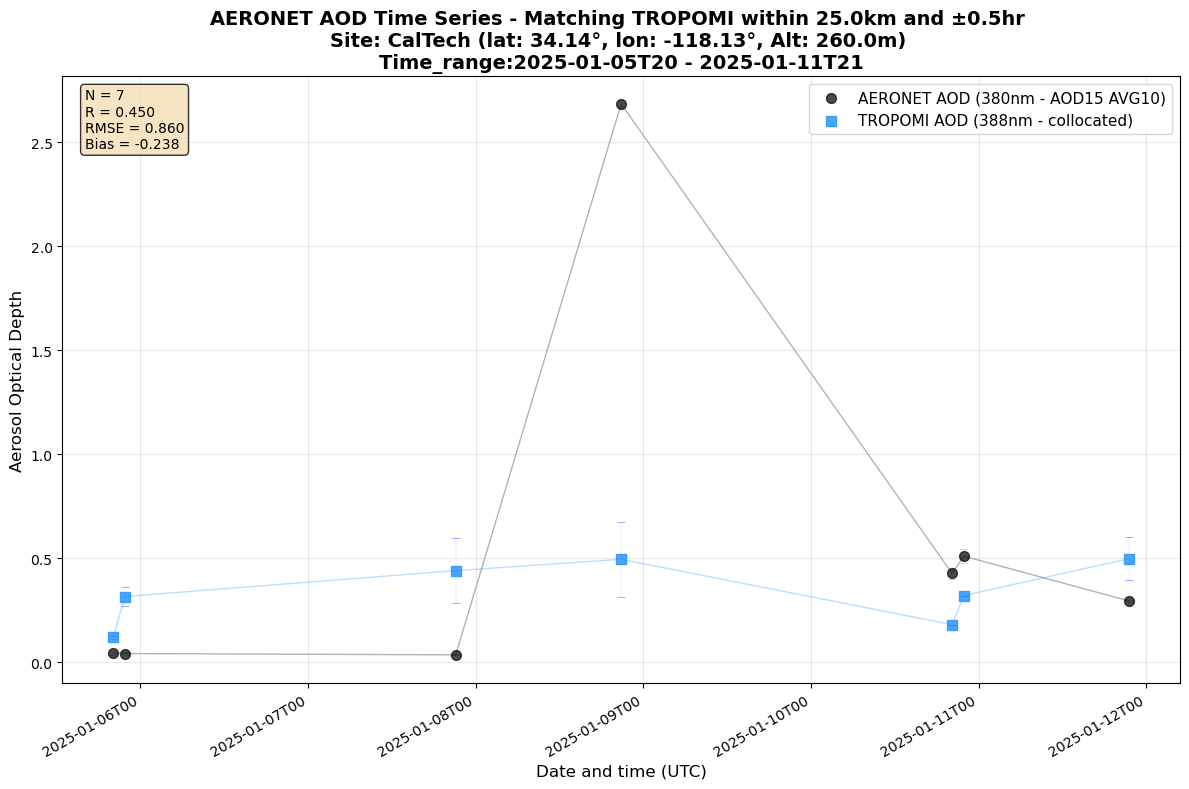

     Scatter plot saved for CalTech: ./Results_AOD_collocation_LA_v5/plots/scatter_CalTech.png


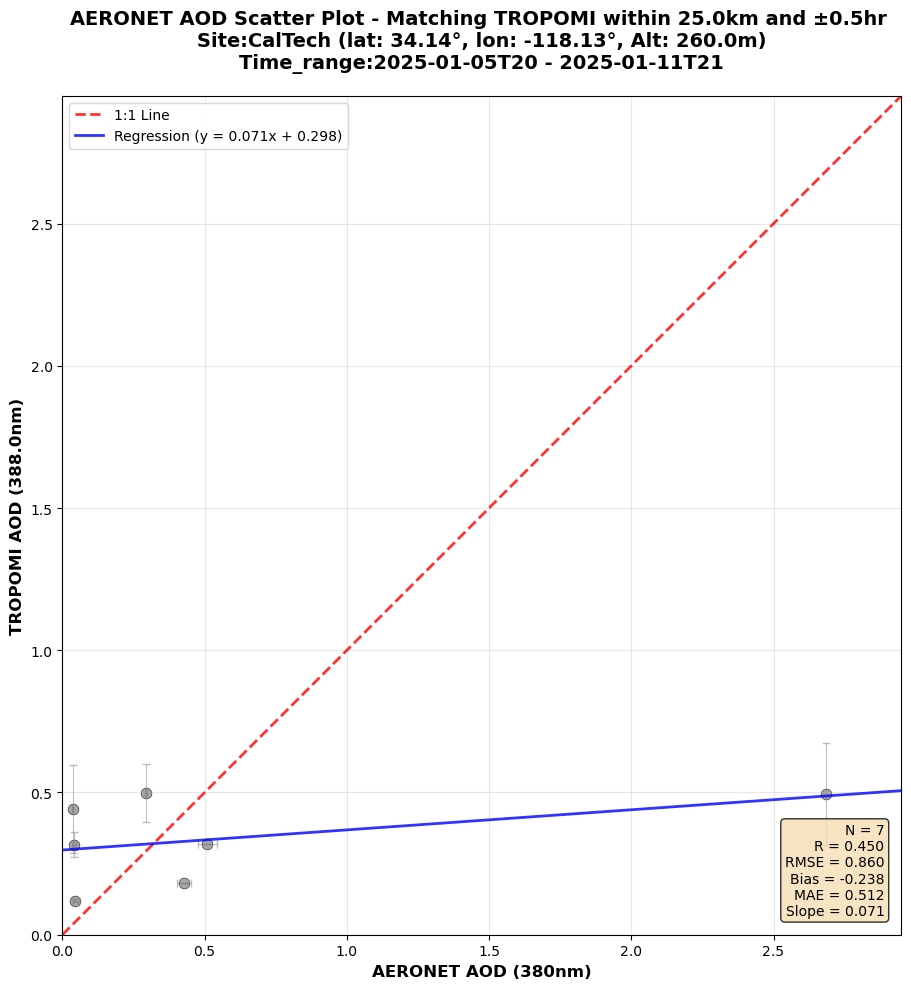

  - Created plots for Goldstone
     Time series plot saved for Goldstone: ./Results_AOD_collocation_LA_v5/plots/time_series_Goldstone.png


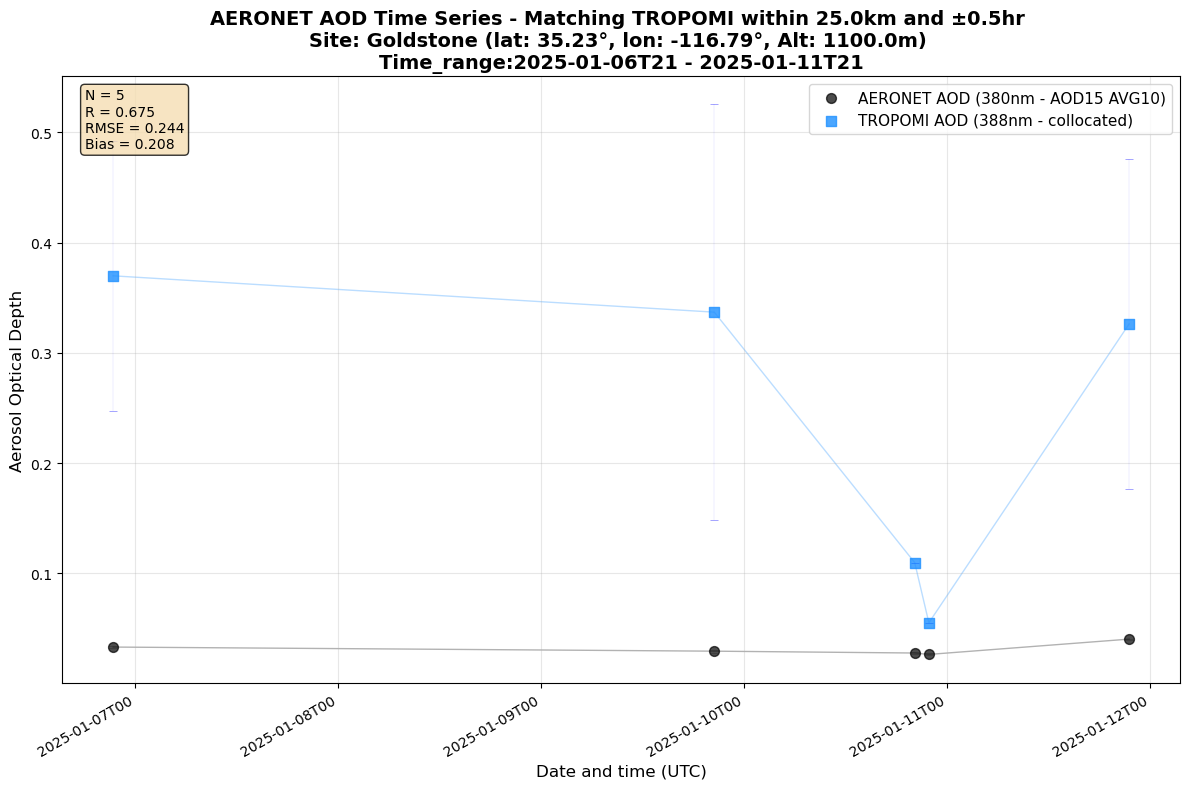

     Scatter plot saved for Goldstone: ./Results_AOD_collocation_LA_v5/plots/scatter_Goldstone.png


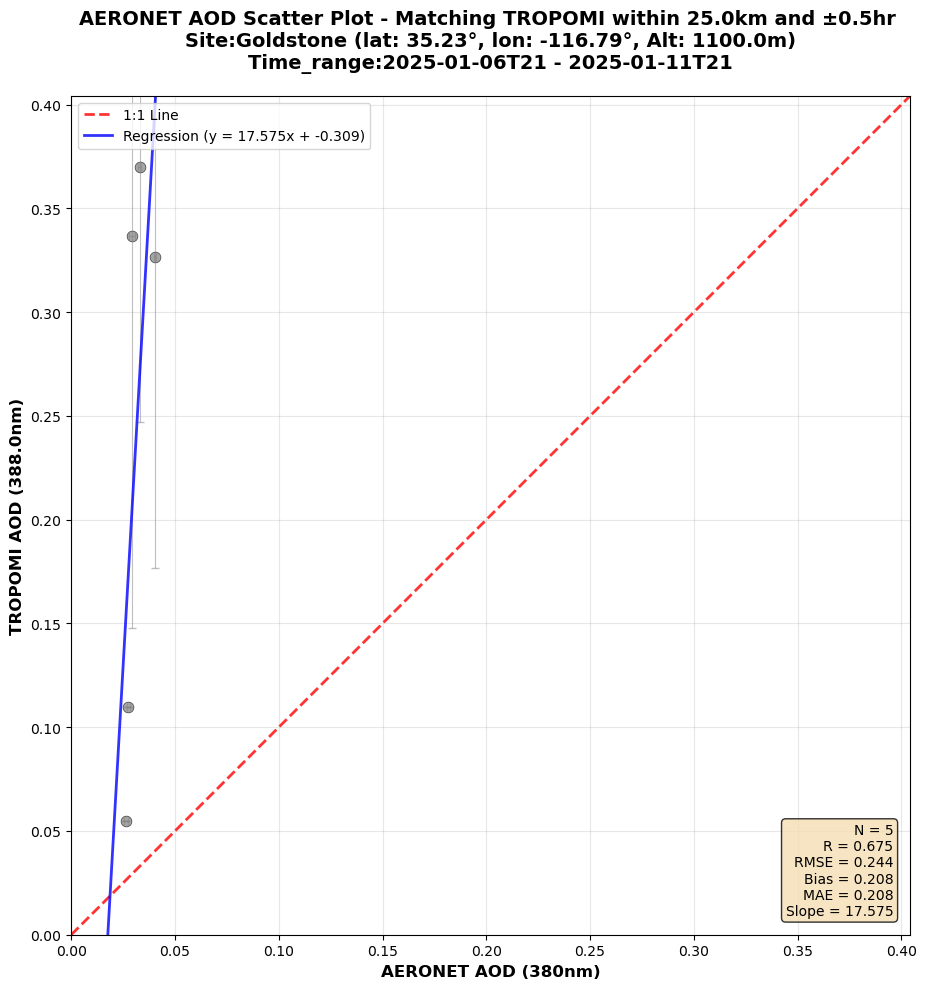

  - Created plots for MISR-JPL
     Time series plot saved for MISR-JPL: ./Results_AOD_collocation_LA_v5/plots/time_series_MISR-JPL.png


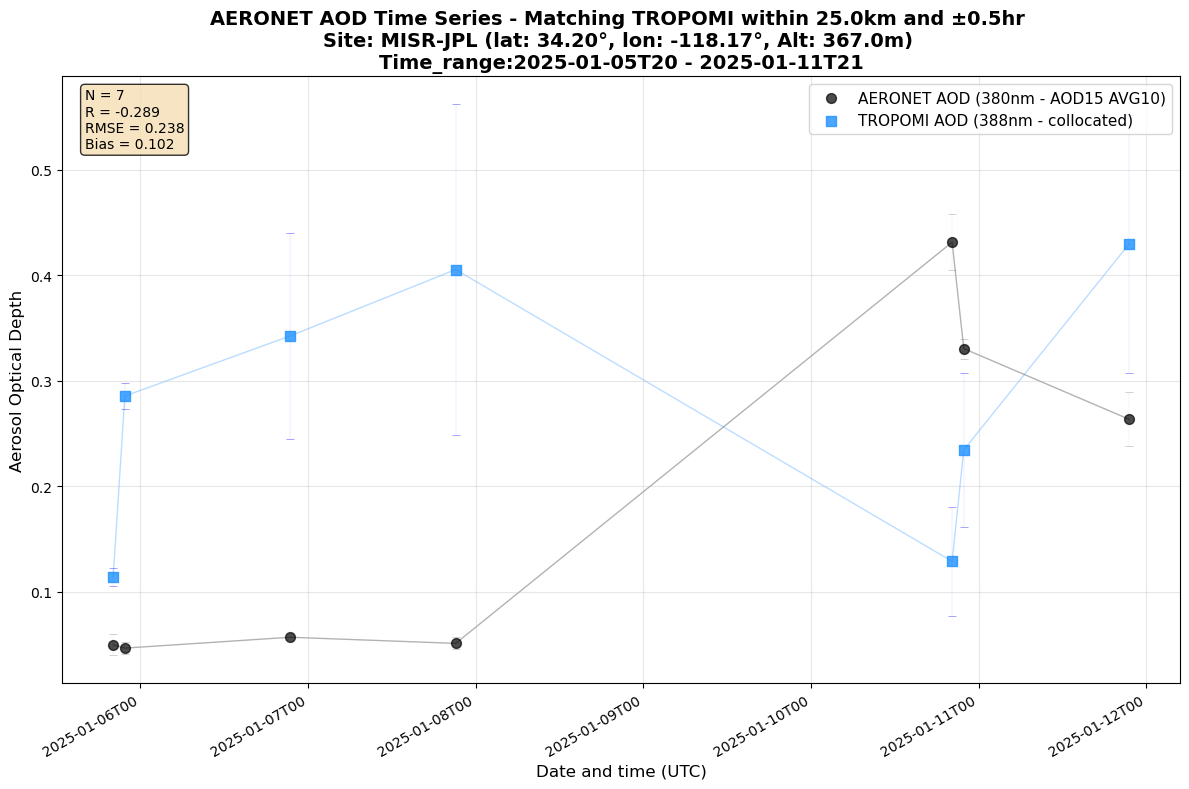

     Scatter plot saved for MISR-JPL: ./Results_AOD_collocation_LA_v5/plots/scatter_MISR_JPL.png


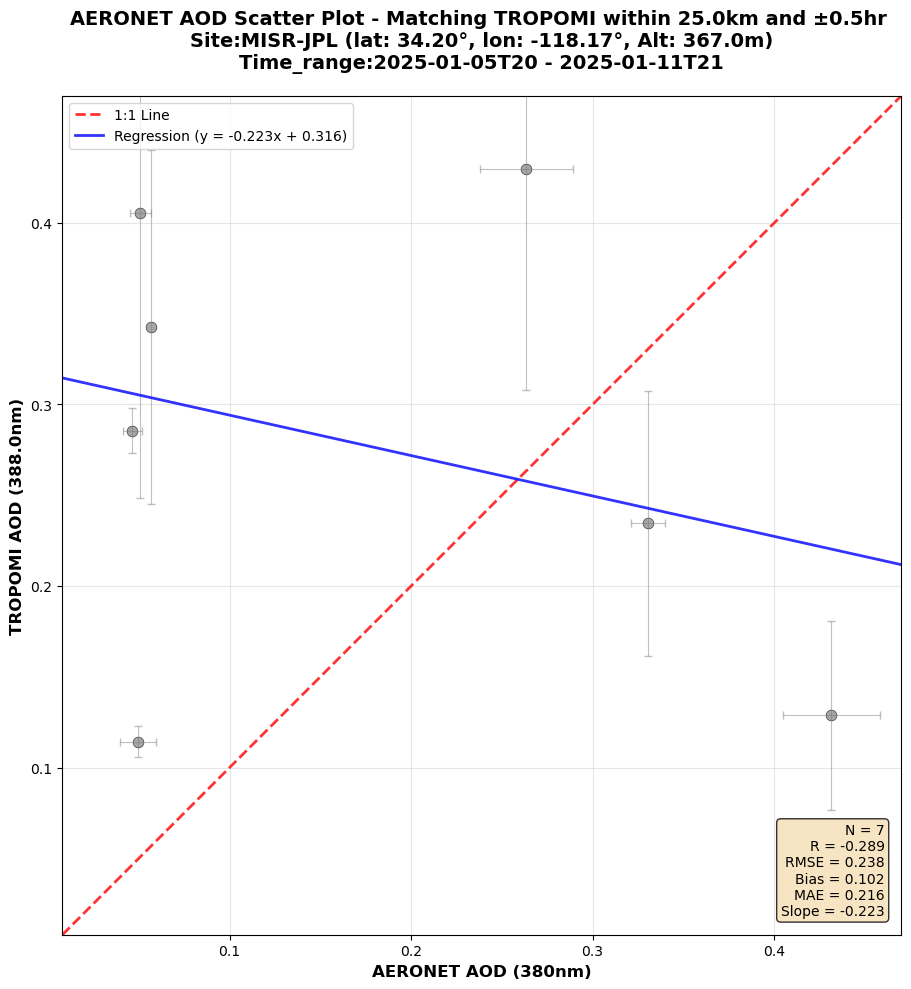


Collocation Summary:
 - Total collocations: 19
 - Unique AERONET sites: 3
 - Unique TROPOMI files: 11
 - Date range: 2025-01-05 20:05 to 2025-01-11 21:33

Results and plots saved in: ./Results_AOD_collocation_LA_v5

Collocation analysis complete!
CPU times: user 19 s, sys: 7.08 s, total: 26.1 s
Wall time: 1min 5s


In [4]:
%%time
# Then create the object with these values:
collocation = TropomiAeronetCollocation(
    spatial_radius_km=spatial_radius_km,
    temporal_window_hours=temporal_window_hours,
    output_dir=output_dir,
    target_wavelength=target_wavelength,
    start_date=start_date,
    end_date=end_date,
    bounding_box=selected_bbox,
    aeronet_data_type=aeronet_data_type,
    aeronet_data_format=aeronet_data_format, 
    tropomi_data_shortname=tropomi_data_shortname, 
    tropomi_data_version=tropomi_data_version
)

# Perform collocation
print("\nStarting collocation process...")

df_results = collocation.collocate_data()

# Fix: Check if results exist before proceeding
if df_results is None or len(df_results) == 0:
     print("No collocations found. Cannot proceed with analysis.")
     print("Possible reasons:")
     print("1. No TROPOMI data overlaps with AERONET sites in the specified time period")
     print("2. Temporal bin size is too restrictive")
     print("3. Spatial radius around AERONET sites is too small")
     print("4. Data quality filters are too strict")
     #return

 # Only proceed if we have valid results
print(f"Found {len(df_results)} collocations, proceeding with analysis...")

# Get the selected wavelength from results
tropomi_wavelength = df_results['tropomi_wavelength'].unique()[0]  # Take first if multiple
#selected_wavelength = df_results['tropomi_wavelength']  # Take first if multiple
print(f"TROPOMI wavelength used: {tropomi_wavelength} nm")

# Generate visualizations and statistics if results were found
if df_results is not None and len(df_results) > 0:
    print("\nGenerating visualizations...")

    # Map of collocations
    try:
        collocation.plot_collocation_map(df_results)
    except Exception as e:
        print(f"Error generating collocation map: {str(e)}")

    # Scatter plot all site
    try:
        collocation.plot_validation_scatter(df_results, save_plots=True) 
    except Exception as e:
        print(f"Error generating scatter plot: {str(e)}")

    # Time series and scatter plot for individual sites
    print("\nGenerating time series and scatter plots for each site...")
    for site in df_results['site_name'].unique():
        print(f"  - Created plots for {site}")
        # Time series for individual sites
        try:
            collocation.plot_site_time_series(df_results, site, tropomi_wavelength, save_plots=True)

        except Exception as e:
            print(f"  - Error time series plotting {site}: {str(e)}")

        # Individual site scatter plots
        try:
            collocation.plot_site_scatter(df_results, site, save_plots=True)
        except Exception as e:
            print(f"  - Error scatter plotting {site}: {str(e)}")


    # Print summary
    print(f"\nCollocation Summary:")
    print(f" - Total collocations: {len(df_results)}")
    print(f" - Unique AERONET sites: {df_results['site_name'].nunique()}")
    print(f" - Unique TROPOMI files: {len(collocation.tropomi_files)}")

    if len(df_results) > 0:
        date_range_str = f"{df_results['aeronet_datetime'].min().strftime('%Y-%m-%d %H:%M')} to {df_results['aeronet_datetime'].max().strftime('%Y-%m-%d %H:%M')}"
        print(f" - Date range: {date_range_str}")

    print(f"\nResults and plots saved in: {collocation.output_dir}")
else:
    print("\nNo collocation results found. Try adjusting parameters:")
    print("  - Increase spatial_radius_km")
    print("  - Increase temporal_window_hours")
    print("  - Expand bounding box")
    print("  - Extend date range")
    print("  - Check TROPOMI file availability")

print("\nCollocation analysis complete!")